In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import helper

In [2]:
from google.colab import drive
drive.mount('/content/drive')
dir = "/content/drive/My Drive/GNR 638 Kaggle"

Mounted at /content/drive


In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU activated")
else:
  device = torch.device("cpu")

GPU activated


In [ ]:
#device = torch.device("cpu")

In [4]:
import os
os.getcwd()
os.chdir(dir)

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [18]:

train_set = datasets.ImageFolder(dir+"/data2",transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                #transforms.Grayscale(),
                                transforms.ToTensor()]))

train_set, val_set = torch.utils.data.random_split(train_set, [2541,539]) 

In [19]:
train_loader = DataLoader(train_set, batch_size=77, shuffle = True)
test_loader = DataLoader(val_set, batch_size=77, shuffle = True)

In [ ]:
next(iter(test_loader))

In [20]:
class LocationCNN(nn.Module):
    
    def __init__(self):
        super(LocationCNN, self).__init__()
        
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=11, stride = 4, padding = 2),
            nn.BatchNorm2d(48),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=128, kernel_size=5, padding = 2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 192, kernel_size = 3, padding = 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels = 192, out_channels = 192, kernel_size  = 3, padding = 1),
            nn.BatchNorm2d(192),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels = 192, out_channels = 128, kernel_size  = 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.layer6 = nn.Sequential(
            nn.Linear(in_features=6*6*128, out_features=98),
            nn.Dropout2d(0.25),
            nn.Linear(in_features=98,out_features=7),
            nn.Softmax()
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.flatten(out)
        out = self.layer6(out)
        return out



In [28]:
model = LocationCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

LocationCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [ ]:
num_epochs = 20
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_train_list = []
accuracy_list = []
test_loss_list = []
# Lists for knowing classwise accuracy
predictions_list = []
predictions_train_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(77,3,224,224))
        labels = Variable(labels)
        # Forward pass 
        correct = 0
        outputs = model(train)
        predictions_train = torch.max(outputs, 1)[1].to(device)
        predictions_train_list.append(predictions_train)
        correct += (predictions_train == labels).sum()
        total += len(labels)
        
        
        loss = error(outputs,  labels)
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
        
        count += 1
        
        accuracy_train = correct * 100 / float(total)
        iteration_list.append(count)
        accuracy_train_list.append(accuracy)
    # Testing the model
    
        if count % 50000 != 0:
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(77, 3, 224, 224))
                
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
                labels = Variable(labels)
                
            accuracy = correct * 100 / float(total)
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)
        
        if count % 50000!=0:
            print("Iteration: {}, Training Loss: {}, Validation Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iteration: 1, Training Loss: 1.9537831544876099, Validation Accuracy: 16.32653045654297%
Iteration: 2, Training Loss: 1.9252780675888062, Validation Accuracy: 33.95176315307617%
Iteration: 3, Training Loss: 1.71213698387146, Validation Accuracy: 50.46382141113281%
Iteration: 4, Training Loss: 1.634764313697815, Validation Accuracy: 55.10204315185547%
Iteration: 5, Training Loss: 1.6290886402130127, Validation Accuracy: 59.18367385864258%
Iteration: 6, Training Loss: 1.593295693397522, Validation Accuracy: 62.33766174316406%
Iteration: 7, Training Loss: 1.4970428943634033, Validation Accuracy: 68.46011352539062%
Iteration: 8, Training Loss: 1.4590469598770142, Validation Accuracy: 72.17068481445312%
Iteration: 9, Training Loss: 1.5225374698638916, Validation Accuracy: 69.7588119506836%
Iteration: 10, Training Loss: 1.5244532823562622, Validation Accuracy: 75.69573211669922%
Iteration: 11, Training Loss: 1.4230575561523438, Validation Accuracy: 74.95362091064453%
Iteration: 12, Training 

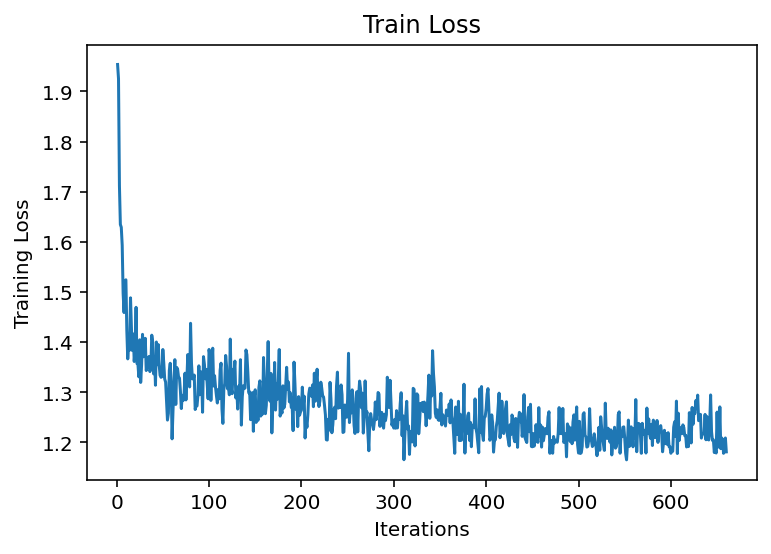

In [33]:
plt.plot(iteration_list,loss_list)
plt.title("Train Loss")
plt.xlabel("Iterations")
plt.ylabel("Training Loss")
plt.show()

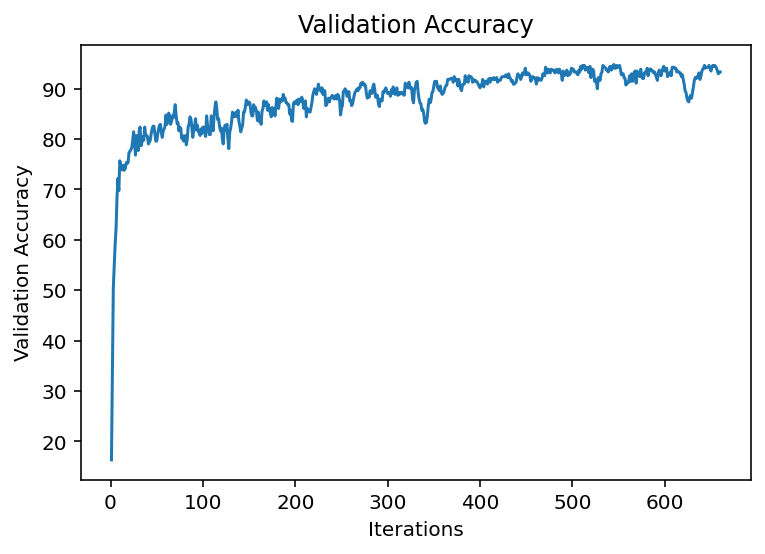

In [34]:
plt.plot(iteration_list,accuracy_list)
plt.title("Validation Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Validation Accuracy")
plt.show()

In [ ]:
""" To save the model """
torch.save(model.state_dict(),"model_name")

In [ ]:
""" To load the model """
model = LocationCNN()
model.load_state_dict(torch.load("model_name"))
model.eval()
model.to(device)